# Offline RL Agent for Loan Approval (Q-Learning Style)

This notebook implements an offline reinforcement learning agent using Q-learning to learn an optimal loan approval policy. The agent learns to maximize expected profit by approving loans that are likely to be repaid and denying those that may default.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from tqdm import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.3.0
Device: cpu


## 2. Load and Sample Data

Load the preprocessed loan data and sample 100,000 records for training.

In [2]:
# Assume df is your full dataset already loaded
df = pd.read_csv('../data/processed/processed_sample.csv')

target_col = 'loan_status'
df_sample = df.sample(n=100_000, random_state=42)

print(f"Sample shape: {df_sample.shape}")
print(f"\nTarget distribution:")
print(df_sample[target_col].value_counts())

Sample shape: (100000, 90)

Target distribution:
loan_status
Fully Paid    79810
Default       20190
Name: count, dtype: int64


## 3. Separate Features and Target

In [3]:
X = df_sample.drop(columns=[target_col])
y = df_sample[target_col].values

# Identify categorical and numeric columns
categorical_cols = [col for col in X.columns if X[col].nunique() <= 20]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

print(f"Number of categorical columns: {len(categorical_cols)}")
print(f"Number of numeric columns: {len(numeric_cols)}")
print(f"\nCategorical columns: {categorical_cols}")

Number of categorical columns: 32
Number of numeric columns: 57

Categorical columns: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'inq_last_6mths', 'pub_rec', 'initial_list_status', 'out_prncp', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'open_acc_6m', 'open_il_12m', 'open_rv_12m', 'chargeoff_within_12_mths', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'tax_liens', 'disbursement_method', 'debt_settlement_flag', 'issue_d_year', 'issue_d_month', 'earliest_cr_line_month', 'last_pymnt_d_year', 'last_pymnt_d_month', 'last_credit_pull_d_year', 'last_credit_pull_d_month']


## 4. Handle Missing Values

In [4]:
# Handle NaN values
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
X[categorical_cols] = X[categorical_cols].fillna("Unknown")

print(f"Missing values after handling: {X.isnull().sum().sum()}")

Missing values after handling: 0


## 5. Preprocessing: Scaling and Encoding

- **Numeric features**: Standardized using StandardScaler
- **Categorical features**: One-hot encoded
- **Target**: Label encoded (Fully Paid=1, Default=0)

In [5]:
# Scale numeric features
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X[numeric_cols])

# One-hot encode categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_categorical = ohe.fit_transform(X[categorical_cols])

# Combine numeric and categorical features
X_processed = np.hstack([X_numeric, X_categorical])

print(f"Processed feature shape: {X_processed.shape}")

Processed feature shape: (100000, 339)


In [6]:
# Encode target: Fully Paid=1, Default=0
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_tensor = torch.tensor(y_encoded, dtype=torch.float32)

print(f"Target classes: {le.classes_}")
print(f"Encoded target distribution: {np.bincount(y_encoded)}")

Target classes: ['Default' 'Fully Paid']
Encoded target distribution: [20190 79810]


## 6. Extract Loan Amount and Interest Rate for Reward Calculation

In [7]:
# Include loan amount & interest rate (for reward computation)
loan_amnt = torch.tensor(X["loan_amnt"].values, dtype=torch.float32)
int_rate = torch.tensor(X["int_rate"].values, dtype=torch.float32)

print(f"Loan amount range: ${loan_amnt.min():.2f} - ${loan_amnt.max():.2f}")
print(f"Interest rate range: {int_rate.min():.2f}% - {int_rate.max():.2f}%")

Loan amount range: $1000.00 - $40000.00
Interest rate range: 5.31% - 30.99%


## 7. Train-Test Split

In [8]:
X_train, X_test, y_train, y_test, loan_train, loan_test, rate_train, rate_test = train_test_split(
    X_processed, y_tensor, loan_amnt, int_rate, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
loan_train = loan_train.reshape(-1, 1)
rate_train = rate_train.reshape(-1, 1)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 80000
Test set size: 20000


## 8. Create DataLoader

In [9]:
train_dataset = TensorDataset(X_train, y_train, loan_train, rate_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

print(f"Number of batches: {len(train_loader)}")

Number of batches: 313


## 9. Define Q-Network Architecture

The Q-network takes the loan application features as input and outputs Q-values for two actions:
- **Action 0**: Deny the loan
- **Action 1**: Approve the loan

In [10]:
class QNetwork(nn.Module):
    def __init__(self, input_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 2 actions: 0 = Deny, 1 = Approve
        )

    def forward(self, x):
        return self.model(x)

model = QNetwork(X_train.shape[1])
print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")


Model architecture:
QNetwork(
  (model): Sequential(
    (0): Linear(in_features=339, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

Total parameters: 51906


## 10. Define Optimizer and Loss Function

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print("Optimizer: Adam")
print(f"Learning rate: 0.001")
print(f"Loss function: MSE")

Optimizer: Adam
Learning rate: 0.001
Loss function: MSE


## 11. Define Reward Function

The reward function implements the business logic:
- **Approve + Fully Paid**: Reward = loan_amount × interest_rate (profit)
- **Approve + Default**: Reward = -loan_amount (loss)
- **Deny**: Reward = 0 (no gain, no loss)

In [12]:
def compute_reward(action, loan_status, loan_amt, int_rate):
    """
    Compute rewards based on action and outcome.
    
    Args:
        action: 0 (deny) or 1 (approve)
        loan_status: 0 (default) or 1 (fully paid)
        loan_amt: loan amount
        int_rate: interest rate
    
    Returns:
        reward: calculated reward
    """
    reward = torch.zeros_like(action, dtype=torch.float32)

    approve_mask = (action == 1)
    fully_paid_mask = (loan_status == 1)
    defaulted_mask = (loan_status == 0)

    # Intersection masks
    approve_fully_paid = approve_mask & fully_paid_mask
    approve_defaulted = approve_mask & defaulted_mask

    # Assign rewards
    reward[approve_fully_paid] = loan_amt[approve_fully_paid] * int_rate[approve_fully_paid]
    reward[approve_defaulted] = -loan_amt[approve_defaulted]

    return reward

print("Reward function defined successfully!")

Reward function defined successfully!


## 12. Training Loop (Offline Q-Learning)

Train the Q-network using offline Q-learning with exploratory actions.

In [13]:
epochs = 5
gamma = 0.9

training_losses = []

for epoch in range(epochs):
    total_loss = 0
    model.train()
    
    for xb, yb, loanb, rateb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        # Forward pass
        q_values = model(xb)  # [batch, 2]
        
        # Random exploratory actions during training
        action = torch.randint(0, 2, (xb.size(0),))

        # Compute rewards
        reward = compute_reward(action, yb, loanb.flatten(), rateb.flatten())
        reward = reward / 10000.0  # Normalize rewards

        # Predicted Q for chosen actions
        q_pred = q_values[torch.arange(len(action)), action]

        # Target = reward (no next state since it's offline)
        q_target = reward

        # Compute loss and backpropagate
        loss = criterion(q_pred, q_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f}")

print("\n✅ Training complete!")

Epoch 1/5: 100%|██████████| 313/313 [00:01<00:00, 229.32it/s]


Epoch 1/5 - Average Loss: 42.5414


Epoch 2/5: 100%|██████████| 313/313 [00:02<00:00, 151.79it/s]


Epoch 2/5 - Average Loss: 5.3313


Epoch 3/5: 100%|██████████| 313/313 [00:03<00:00, 102.39it/s]


Epoch 3/5 - Average Loss: 2.0262


Epoch 4/5: 100%|██████████| 313/313 [00:02<00:00, 154.37it/s]


Epoch 4/5 - Average Loss: 1.5061


Epoch 5/5: 100%|██████████| 313/313 [00:02<00:00, 156.00it/s]

Epoch 5/5 - Average Loss: 1.1970

✅ Training complete!


## 13. Visualize Training Loss

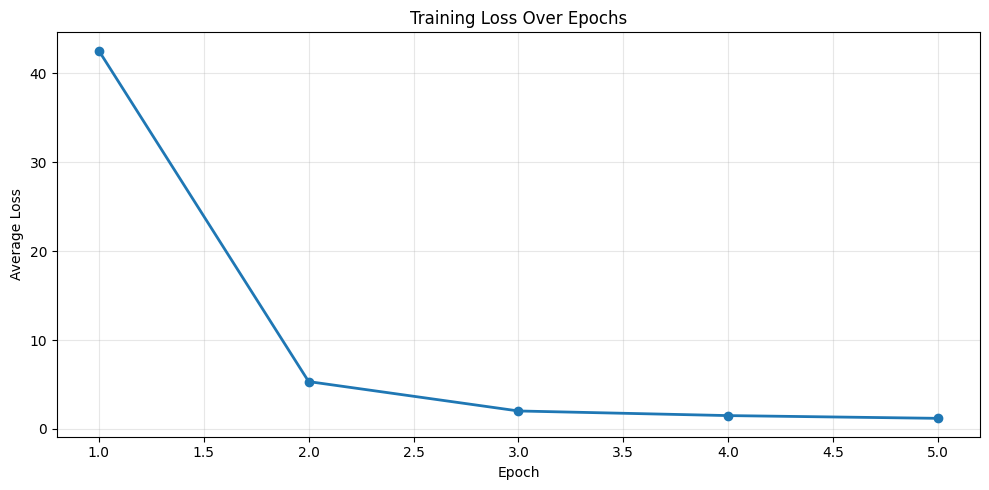

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), training_losses, marker='o', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 14. Evaluate the Policy (Estimated Policy Value)

Evaluate the learned policy on the test set by:
1. Computing Q-values for each test sample
2. Selecting the best action (argmax)
3. Calculating the expected reward

In [15]:
model.eval()
with torch.no_grad():
    q_values = model(X_test)
    actions = torch.argmax(q_values, dim=1)  # Choose best action for each state

    loan_test_tensor = loan_test.reshape(-1)
    rate_test_tensor = rate_test.reshape(-1)

    rewards = compute_reward(actions, y_test, loan_test_tensor, rate_test_tensor)
    
    estimated_policy_value = rewards.mean().item()
    
print("="*70)
print("POLICY EVALUATION RESULTS")
print("="*70)
print(f"\n✅ Estimated Policy Value (RL Agent): ${estimated_policy_value:,.2f}")
print(f"   (Average reward per loan application)")

POLICY EVALUATION RESULTS

✅ Estimated Policy Value (RL Agent): $146,781.77
   (Average reward per loan application)


## 15. Analyze Policy Action Distribution

In [16]:
total = len(actions)
approve_ratio = (actions == 1).float().mean().item() * 100
deny_ratio = (actions == 0).float().mean().item() * 100

print("\nPolicy Action Distribution:")
print(f"  Approve: {approve_ratio:.2f}% ({int(total * approve_ratio / 100):,} applications)")
print(f"  Deny:    {deny_ratio:.2f}% ({int(total * deny_ratio / 100):,} applications)")


Policy Action Distribution:
  Approve: 82.27% (16,454 applications)
  Deny:    17.73% (3,546 applications)


## 16. Visualize Action Distribution

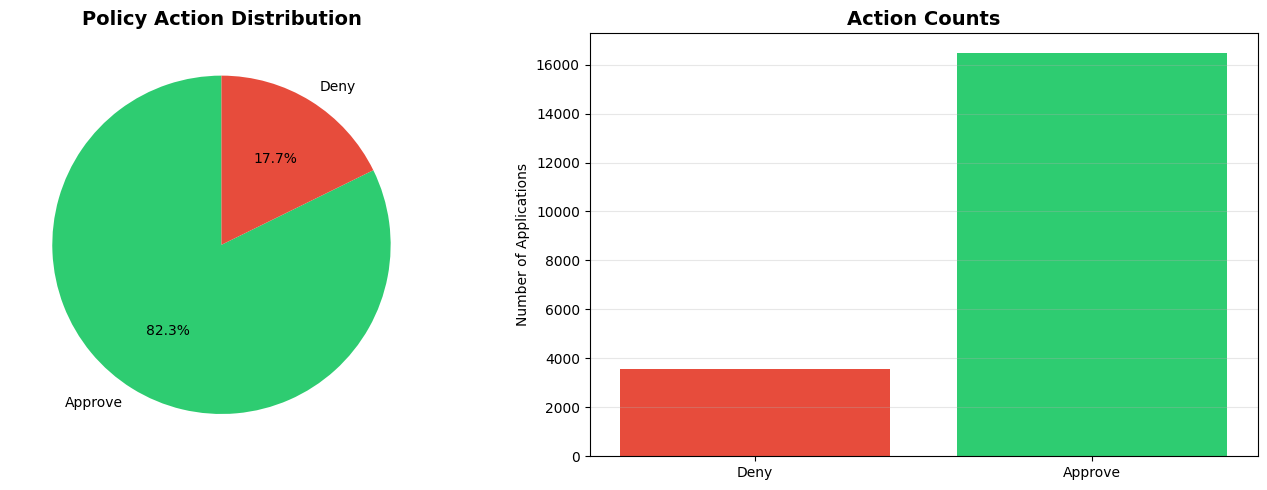

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie([approve_ratio, deny_ratio], 
            labels=['Approve', 'Deny'],
            autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'],
            startangle=90)
axes[0].set_title('Policy Action Distribution', fontsize=14, fontweight='bold')

# Bar chart
actions_np = actions.numpy()
axes[1].bar(['Deny', 'Approve'], 
            [np.sum(actions_np == 0), np.sum(actions_np == 1)],
            color=['#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Number of Applications')
axes[1].set_title('Action Counts', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 17. Detailed Performance Analysis

In [18]:
# Analyze performance by action and outcome
actions_np = actions.numpy()
y_test_np = y_test.numpy()

# Approved loans
approved_mask = (actions_np == 1)
approved_fully_paid = np.sum((actions_np == 1) & (y_test_np == 1))
approved_defaulted = np.sum((actions_np == 1) & (y_test_np == 0))

# Denied loans
denied_mask = (actions_np == 0)
denied_would_pay = np.sum((actions_np == 0) & (y_test_np == 1))
denied_would_default = np.sum((actions_np == 0) & (y_test_np == 0))

print("\nDetailed Performance Breakdown:")
print("="*70)
print(f"\n📈 APPROVED LOANS:")
print(f"   - Would be fully paid: {approved_fully_paid:,} ({approved_fully_paid/total*100:.2f}%)")
print(f"   - Would default: {approved_defaulted:,} ({approved_defaulted/total*100:.2f}%)")
if np.sum(approved_mask) > 0:
    print(f"   - Success rate: {approved_fully_paid/np.sum(approved_mask)*100:.2f}%")

print(f"\n📉 DENIED LOANS:")
print(f"   - Would have been fully paid: {denied_would_pay:,} ({denied_would_pay/total*100:.2f}%)")
print(f"   - Would have defaulted: {denied_would_default:,} ({denied_would_default/total*100:.2f}%)")
if np.sum(denied_mask) > 0:
    print(f"   - Correct denials: {denied_would_default/np.sum(denied_mask)*100:.2f}%")


Detailed Performance Breakdown:

📈 APPROVED LOANS:
   - Would be fully paid: 16,120 (80.60%)
   - Would default: 334 (1.67%)
   - Success rate: 97.97%

📉 DENIED LOANS:
   - Would have been fully paid: 3 (0.01%)
   - Would have defaulted: 3,543 (17.71%)
   - Correct denials: 99.92%


## 18. Calculate Total Profit/Loss

In [19]:
total_reward = rewards.sum().item()
avg_reward_per_approval = rewards[actions == 1].mean().item() if torch.sum(actions == 1) > 0 else 0

print("\n💰 Financial Summary:")
print("="*70)
print(f"Total Expected Profit/Loss: ${total_reward:,.2f}")
print(f"Average Reward per Application: ${estimated_policy_value:,.2f}")
print(f"Average Reward per Approval: ${avg_reward_per_approval:,.2f}")


💰 Financial Summary:
Total Expected Profit/Loss: $2,935,635,200.00
Average Reward per Application: $146,781.77
Average Reward per Approval: $178,414.67
